# SML Pratical

Music Genre Classification


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset

In [14]:
### data loading ###
X = pd.read_csv('data/X_train.csv', index_col = 0, header=[0, 1, 2]) # inputs 
y = pd.read_csv('data/y_train.csv', index_col = 0).squeeze('columns') # labels

# total number of rows and columns(attributes)
n, p = np.shape(X)


In [15]:
### map the character labels to numerical ### 

class_label_mapping = {}

def transform_labels_to_numbers(labels):
    """
    Take class labels, and transform them to 0, 1, ..., K (where K is total number of classes)

    :param labels: 1d pd Series, contains class labels
    
    :return transformed_labels: 1d numpy array of the same shape as labels, contains numerical values
    :return class_label_mapping: dictionary, records the correspondance between numbers and original classes
    """
    unique_labels = set(labels)
    
    for i, label in enumerate(unique_labels):
        class_label_mapping[label] = i

    transformed_labels = [class_label_mapping[label] for label in labels]
    
    return transformed_labels, class_label_mapping

y_labelled = y.copy()
y, label_mapping = transform_labels_to_numbers(y)
index_label_mapping = {v: k for k, v in label_mapping.items()} # reverse dictionary
y = pd.Series(y)

## EDA

In [18]:
### check class weights ###
print(y_labelled.value_counts() / n)

Folk             0.129167
Electronic       0.127833
Instrumental     0.126500
Pop              0.126333
Experimental     0.123167
Rock             0.122833
Hip-Hop          0.122333
International    0.121833
Name: Genre, dtype: float64


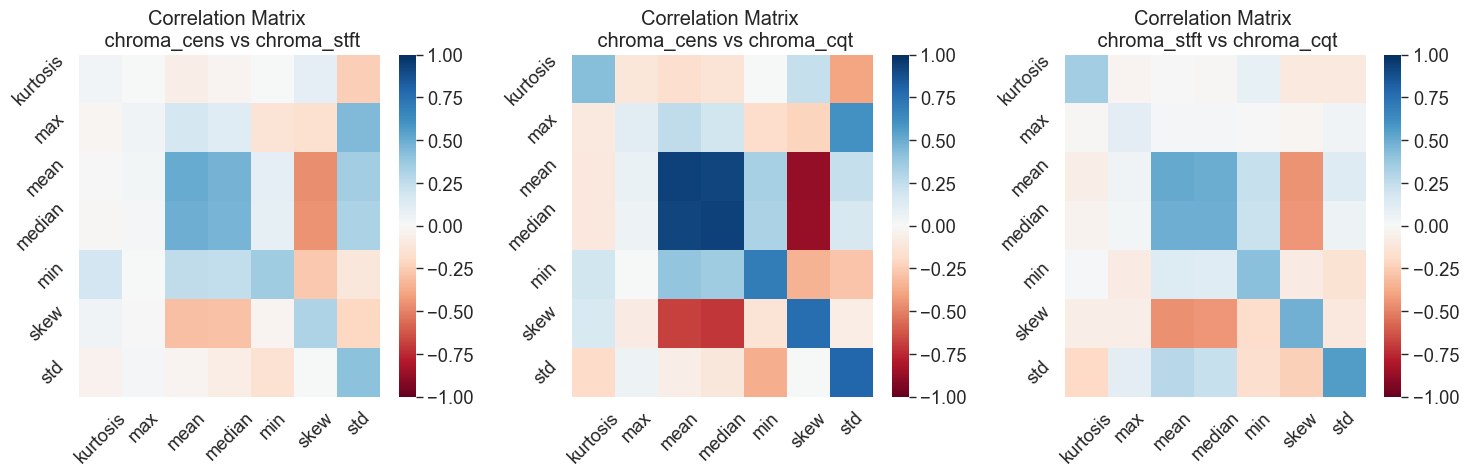

In [111]:
### correlation test ###

chroma='01'
group1_feature = 'chroma_cens'
group2_feature = 'chroma_stft'
group3_feature = 'chroma_cqt'
group1 = X.loc[:, (X.columns.get_level_values('feature') == group1_feature) & (X.columns.get_level_values('number') == chroma)]
group1_ticks = group1.columns.get_level_values('statistics')
group2 = X.loc[:, (X.columns.get_level_values('feature') == group2_feature) & (X.columns.get_level_values('number') == chroma)]
group2_ticks = group2.columns.get_level_values('statistics')
group3 = X.loc[:, (X.columns.get_level_values('feature') == group3_feature) & (X.columns.get_level_values('number') == chroma)]
group3_ticks = group3.columns.get_level_values('statistics')

# Calculate correlation matrices between groups
corr_group1_group2 = np.corrcoef(group1, group2, rowvar=False)
corr_group1_group3 = np.corrcoef(group1, group3, rowvar=False)
corr_group2_group3 = np.corrcoef(group2, group3, rowvar=False)

# Plot heatmaps
plt.figure(figsize=(15, 5))
sns.set_context("paper", font_scale=1.5)  # Adjust font_scale as needed
sns.set_style("whitegrid")

plt.subplot(1, 3, 1)
ax1 = sns.heatmap(corr_group1_group2[:7, 7:], cmap='RdBu', xticklabels=group1_ticks, yticklabels=group2_ticks, 
            vmin=-1, vmax=1)
plt.title(f'Correlation Matrix \n {group1_feature} vs {group2_feature}')

plt.subplot(1, 3, 2)
ax2 = sns.heatmap(corr_group1_group3[:7, 7:], cmap='RdBu', xticklabels=group1_ticks, yticklabels=group3_ticks, 
            vmin=-1, vmax=1)
plt.title(f'Correlation Matrix \n {group1_feature} vs {group3_feature}')

plt.subplot(1, 3, 3)
ax3 = sns.heatmap(corr_group2_group3[:7, 7:], cmap='RdBu', xticklabels=group2_ticks, yticklabels=group3_ticks, 
            vmin=-1, vmax=1)
plt.title(f'Correlation Matrix \n {group2_feature} vs {group3_feature}')

# Rotate xticks and yticks
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=45)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
ax3.set_yticklabels(ax3.get_yticklabels(), rotation=45)

plt.tight_layout()
plt.show()

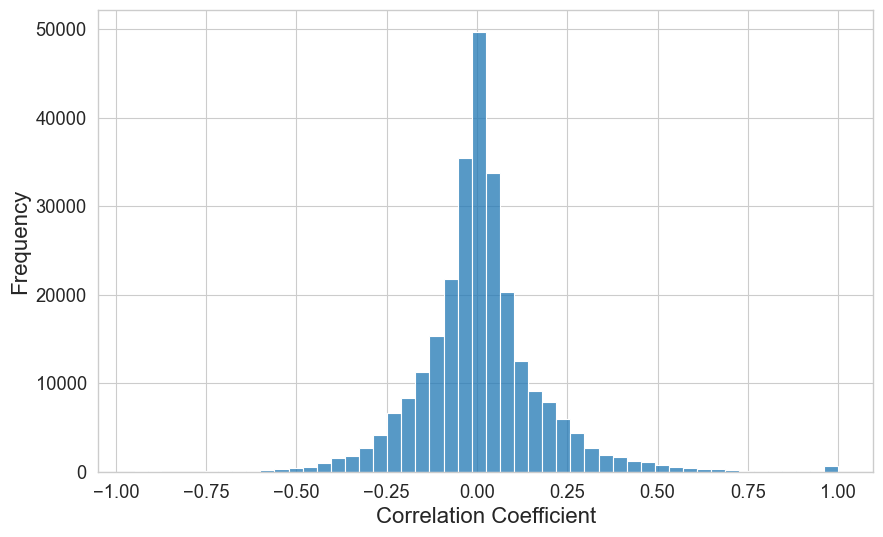

In [110]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Visualize the distribution of correlation values
plt.figure(figsize=(10, 6))
sns.histplot(correlation_matrix.values.flatten(), bins=50)
plt.xlabel('Correlation Coefficient', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In [119]:
### test normality of each class(genre) ###

from scipy.stats import shapiro, kstest

# Iterate over unique class labels
for label in np.unique(y_labelled):
    # Select data points corresponding to the current class
    X_class = X[y_labelled == label]
    
    # Perform Shapiro-Wilk test
    stat, p = shapiro(X_class)
    print(f"Genre {label}: Shapiro-Wilk test statistic = {stat}, p-value = {p}")

Genre Electronic: Shapiro-Wilk test statistic = 0.11254143714904785, p-value = 0.0
Genre Experimental: Shapiro-Wilk test statistic = 0.10461211204528809, p-value = 0.0
Genre Folk: Shapiro-Wilk test statistic = 0.09869629144668579, p-value = 0.0
Genre Hip-Hop: Shapiro-Wilk test statistic = 0.11191195249557495, p-value = 0.0
Genre Instrumental: Shapiro-Wilk test statistic = 0.09389501810073853, p-value = 0.0
Genre International: Shapiro-Wilk test statistic = 0.10848486423492432, p-value = 0.0
Genre Pop: Shapiro-Wilk test statistic = 0.10542094707489014, p-value = 0.0
Genre Rock: Shapiro-Wilk test statistic = 0.10738164186477661, p-value = 0.0


In [177]:
### Plot TSNE to visualise the classes ###
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LDA to reduce dimensions
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_scaled, y_labelled)
X_LDA = LDA_model.transform(X_scaled)

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import mrmr
from mrmr import mrmr_classif

X_all = pd.read_csv('data/X_train.csv', index_col = 0, header=[0, 1, 2]) # inputs of the training set
y_all = pd.read_csv('data/y_train.csv', index_col = 0) # outputs of the training set

selected_features = mrmr_classif(X_all, y_all, K=250)
X_reduced = X_all[selected_features]

100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


In [178]:
from sklearn.manifold import TSNE

# Assuming X_train is your high-dimensional data and y_train are the labels
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_LDA)

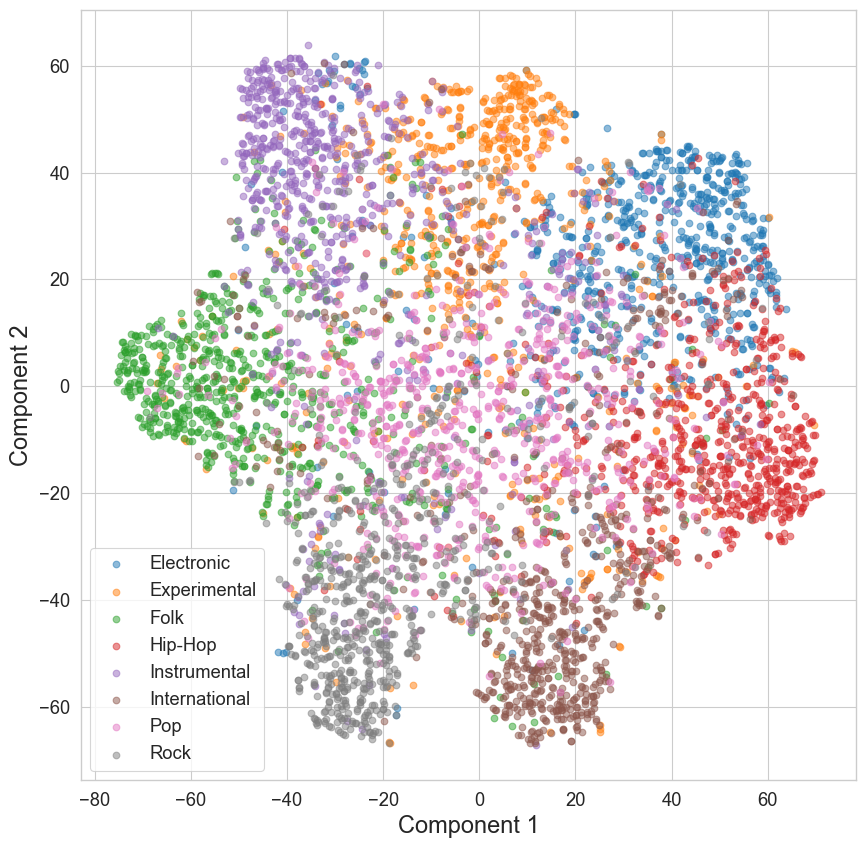

In [179]:
fig, ax = plt.subplots(figsize=(10, 10))

# Create a scatter plot, coloring the points based on y_train labels
for label in np.unique(y_labelled):
    # Find points with this label
    indices = np.where(y_labelled == label)
    # Plot these points with a label
    ax.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label=label, alpha=0.5)

ax.legend()
# ax.set_title(f'2D visualisation of X using t-SNE, PCA with {n_comps} components')
ax.set_xlabel('Component 1', fontsize=17)
ax.set_ylabel('Component 2', fontsize=17)
plt.savefig('figures/tsne_lda.png', dpi=300)

## SVM

In [31]:
### pre-processing ###
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

### split into train and test set  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

### normalisation 
scaler = preprocessing.MinMaxScaler() # all mapped to [0, 1], uniform scaling
# the normaliser only uses information from the training set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
SVM = SVC(C=3, kernel='rbf', gamma='scale', random_state=2023) 
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
print(f'{accuracy_score(y_pred, y_test)}')

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print(f'{accuracy_score(y_pred, y_test)}')

0.4575


In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix

def plot_confusion(y_pred, y_test, title=''):
    """ Plot the confusion matrix """
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix(y_pred, y_test), cmap='viridis', interpolation='nearest')
    plt.colorbar(label='matched pairs')
    plt.title(f'Plot of confusion matrix {title}')
    plt.xlabel('genre')
    plt.ylabel('genre')
    plt.show()

In [ ]:
### split into train and test set  
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=466) 

### normalisation 
scaler = preprocessing.StandardScaler() # all mapped to [0, 1], uniform scaling
# the normaliser only uses information from the training set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### chroma choice

In [43]:
### split into train and test set  
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=466) 

### normalisation 
scaler = preprocessing.StandardScaler() # all mapped to [0, 1], uniform scaling
# the normaliser only uses information from the training set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### feature engineering ###
# choose appropriate chromagram
seeds = np.random.randint(0, 2025, 5)

chromas = {'chroma_cens', 'chroma_cqt', 'chroma_stft'}
# perform base estimator
for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) 

    ### normalisation 
    scaler = preprocessing.StandardScaler() # all mapped to [0, 1], uniform scaling
    # the normaliser only uses information from the training set
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    SVM = SVC(C=2, kernel='rbf', gamma='scale', random_state=seed) 
    SVM.fit(X_train_scaled, y_train)
    y_pred = SVM.predict(X_test_scaled)
    print(f'{accuracy_score(y_pred, y_test)} without removing features, seed={seed}')
    for chroma_choice in chromas:
        # select chromagram
        removed_chromas = chromas.copy()
        removed_chromas.remove(chroma_choice)
        removed_chromas = list(removed_chromas)
        X_train_reduced = X_train_scaled[:, (X.columns.get_level_values('feature') != removed_chromas[0]) 
                                & (X.columns.get_level_values('feature') != removed_chromas[1])]
        X_test_reduced = X_test_scaled[:, (X.columns.get_level_values('feature') != removed_chromas[0]) 
                                & (X.columns.get_level_values('feature') != removed_chromas[1])]

        # SVM:  
        SVM = SVC(C=2, kernel='rbf', gamma='scale', random_state=seed) 
        SVM.fit(X_train_reduced, y_train)
        y_pred = SVM.predict(X_test_reduced)
        print(f'{accuracy_score(y_pred, y_test)} using {chroma_choice}, seed={seed}')

0.6383333333333333 using chroma_cens
0.6541666666666667 using chroma_stft
0.64 using chroma_cqt


### IGR

In [24]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4) 

kbest = SelectKBest(score_func=mutual_info_classif, k=350)
kbest.fit(X_train, y_train)

X_train_selected = kbest.transform(X_train)
X_test_selected = kbest.transform(X_test)

scaler = preprocessing.StandardScaler() # all mapped to [0, 1], uniform scaling
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


In [25]:
## count the number of features selected from each group of features
selected_columns = X.columns[kbest.get_support()]
features = np.unique(X.columns.get_level_values('feature'))
category_counts = {}
for feature in features:
    category_counts[feature] = np.sum(selected_columns.get_level_values('feature') == feature)
category_counts

{'chroma_cens': 25,
 'chroma_cqt': 40,
 'chroma_stft': 72,
 'mfcc': 107,
 'rmse': 5,
 'spectral_bandwidth': 7,
 'spectral_centroid': 7,
 'spectral_contrast': 46,
 'spectral_rolloff': 7,
 'tonnetz': 27,
 'zcr': 7}

In [7]:
## perform SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

params_SVM = {
    'kernel': ['rbf'], # the kernel used
    'C': [2.5], # regularisation strength is 1/C 
    'gamma': ['scale'] # the scale of rbf and poly kernels
}

svm = SVC()
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

grid_search = GridSearchCV(svm, params_SVM, cv=10, scoring='accuracy')
# Fit the GridSearchCV object to the data
grid_search.fit(X_scaled, y)

# Get the results
cv_results = grid_search.cv_results_

# Extract the mean test scores and their standard deviations
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Calculate the confidence interval for each iteration
conf_interval = 1.96 * (std_test_scores / np.sqrt(5))  # Assuming 5-fold cross-validation

# Print the accuracy of each iteration and its confidence interval
for mean_score, std_score, ci in zip(mean_test_scores, std_test_scores, conf_interval):
    print("Accuracy: {:.4f} +- {:.4f}".format(mean_score, ci))

Accuracy: 0.6273 +- 0.0119


### MRMR

In [164]:
# use chroma_stft as suggested above
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=301) 


In [165]:
import mrmr
from mrmr import mrmr_classif

selected_features = mrmr_classif(X_train, 
                                 y_train, 
                                 K=350)

100%|██████████| 350/350 [01:14<00:00,  4.72it/s]


In [168]:
# scaling using standardisation
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

scaler = preprocessing.StandardScaler() # all mapped to [0, 1], uniform scaling

# choose appropriate number of features
n_features = np.arange(50, 350, 50)
accs = []
accs_train = []

for n in n_features:
    X_train_selected = X_train[selected_features[:n]]
    X_test_selected = X_test[selected_features[:n]]
    
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    svm = SVC(C=1.5, 
            kernel='rbf',
            gamma='scale',
            probability=False,
            random_state=18) 
    svm.fit(X_train_scaled, y_train)
    y_pred = svm.predict(X_test_scaled)
    accs.append(accuracy_score(y_pred, y_test))

    y_train_pred = svm.predict(X_train_scaled)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accs_train.append(accuracy_score(y_train_pred, y_train))

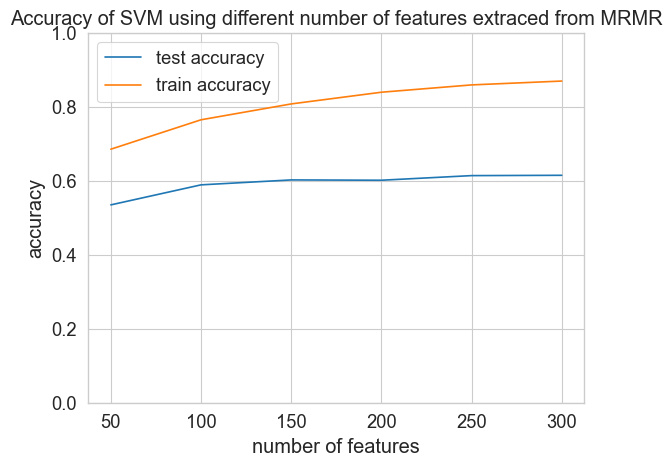

In [169]:
plt.plot(n_features, accs, label='test accuracy')
plt.plot(n_features, accs_train, label='train accuracy')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracy of SVM using different number of features extraced from MRMR')
plt.legend()

plt.show()

In [170]:
## best accuracy
max(accs)

0.6158333333333333

### Statistics selection

In [20]:
# try removing statistics
X_reduced = X.loc[:, (X.columns.get_level_values('feature') != removed_chromas[0]) 
              & (X.columns.get_level_values('feature') != removed_chromas[1])]

statistics = set(X.columns.get_level_values('statistics').unique())

for statistic in statistics:
    removed_statistics = statistics.copy()
    removed_statistics.remove(statistic)
    removed_statistics = list(removed_statistics)
    feature_indices = X_reduced.columns.get_level_values('statistics').isin(removed_statistics)
    X_train_reduced_2 = X_train_reduced[:, feature_indices] 
    X_test_reduced_2 = X_test_reduced[:, feature_indices] 

    # SVM:  
    svm = SVC(C=2, kernel='rbf', gamma='scale', probability=True, random_state=492) 
    svm.fit(X_train_reduced_2, y_train)
    y_pred = svm.predict(X_test_reduced_2)
    print(f'test accuracy: {accuracy_score(y_pred, y_test)} when removing {statistic}')

test accuracy: 0.6466666666666666 when removing median
test accuracy: 0.6408333333333334 when removing min
test accuracy: 0.655 when removing skew
test accuracy: 0.6483333333333333 when removing kurtosis
test accuracy: 0.6441666666666667 when removing mean
test accuracy: 0.6291666666666667 when removing std
test accuracy: 0.6416666666666667 when removing max


conclusion: do not remove any statistics!

## EDA

Genre 0: Weight 0.12916666666666668
Genre 1: Weight 0.12233333333333334
Genre 2: Weight 0.12283333333333334
Genre 3: Weight 0.12183333333333334
Genre 4: Weight 0.12783333333333333
Genre 5: Weight 0.1265
Genre 6: Weight 0.12633333333333333
Genre 7: Weight 0.12316666666666666


In [ ]:
print(f"features: {X.columns.get_level_values('feature').unique().tolist()}")
print(f"statistics: {X.columns.get_level_values('statistics').unique().tolist()}")

features: ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse', 'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast', 'spectral_rolloff', 'tonnetz', 'zcr']
statistics: ['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']


In [ ]:
#  (may not be useful) plot correlations for each set of statistics

statistics = X.columns.get_level_values('statistics').unique()

for statistic in statistics:
    # obtain the columns for each feature
    cols = [col for col in X if col[1] == statistic]
    # find the correlation matrix
    corr = X[cols].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title(f'Correlation Heatmap (for {statistic})', fontsize = 25)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

## AdaBoost.MH with decision trees

In [42]:
### pre-processing ###
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier

### split into train and test set  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024) 

### normalisation 
scaler = preprocessing.MinMaxScaler() # all mapped to [0, 1], uniform scaling
# the normaliser only uses information from the training set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

weak_learner = DecisionTreeClassifier(max_leaf_nodes=5, max_depth=20)
# weak_learner = GaussianNB()
# weak_learner = LinearSVC(random_state=2024, tol=1e-5)

ada_tree = AdaBoostClassifier(estimator= weak_learner, n_estimators = 300, algorithm="SAMME", random_state=2024)
ada_tree.fit(X_train_scaled, y_train)

In [ ]:
y_pred = ada_tree.predict(X_test_scaled)
acc = accuracy_score(y_pred, y_test)
print(f'test accuracy: {acc}')

y_train_pred = svm.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Generalisation gap:", accuracy_train - accuracy_score(y_pred, y_test))

## PCA for dimension reduction

In [ ]:
### use PCA to reduce the dimension ###
from sklearn.decomposition import PCA

# perform the full PCA decomposition
pca = PCA(n_components=p)
# find the principal compoennts
X_train_PC = pd.DataFrame(data = pca.fit_transform(X_train_scaled), columns = [f'PC {i}' for i in range(1, p+1)])

# concatenate labels 
data_PCA = pd.concat([X_train_PC, y_train], axis=1)

explained_variances = pca.explained_variance_ratio_


Text(0, 0.5, 'ratio of explained variance')

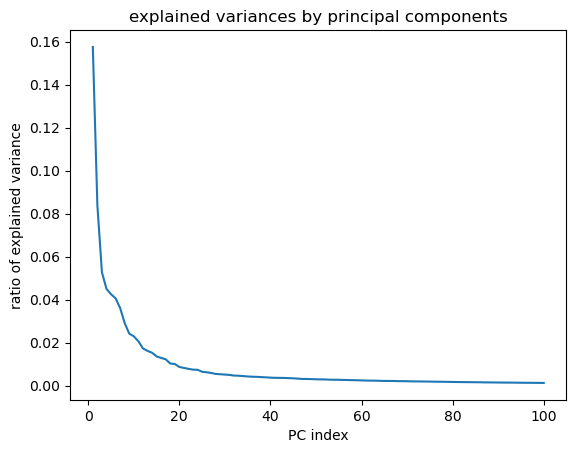

In [ ]:
plt.plot(range(1, 101), explained_variances[:100])
plt.title('explained variances by principal components')
plt.xlabel('PC index')
plt.ylabel('ratio of explained variance')

In [ ]:
### by elbow method, take roughly 20 principal components ###

n_PCA = 20

elbow method: take around 20 PCs as features

## Classical Training Models
Naive Bayes, two-layer perceptron, linear SVM, kernel SVM, random forests (and with gradient boosting) 

In [ ]:
### Try Various Machien Learning Algorithms ###
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier

In [ ]:
### casual trainings with no tuning ###
nb =  GaussianNB() # Naive bayes: no randomness, no parameters
sgd = SGDClassifier(max_iter=4000, random_state=2024)
tree = DecisionTreeClassifier(random_state=2024)
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=2024)
svm = SVC(decision_function_shape="ovo", random_state=2024)
lg = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=2024)
nn = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(64, 8), random_state=2024) # single layer perceptron
xgb = XGBClassifier(n_estimators=500, learning_rate=0.04, random_state=2024)
xgbrf = XGBRFClassifier(objective= 'multi:softmax', random_state=2024)

algorithms_notuning = {
    'naive_Bayes': nb,
    'SGD' : sgd,
    'Decision_tree': tree,
    'random_forest': rf,
    'SVM': svm,
    'logistic_regression': lg,
    'neural network': nn,
    'cross-gradient boosting tree': xgb,
    'cross-gradient boosting': xgbrf
}

### PCA for dimension-reduction

In [ ]:
## use PCA to reduce dimension. n = 20
pca_20 = PCA(n_components=n_PCA)
X_train_PC = pd.DataFrame(data = pca_20.fit_transform(X_train_scaled), columns = [f'PC {i}' for i in range(1, n_PCA+1)])

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# transform test set using PCA fitted with training set
X_test_PCA = pd.DataFrame(data=pca_20.transform(X_test_scaled), columns = [f'PC {i}' for i in range(1, n_PCA+1)])

def model_PCA(model, name):
    """
    Train a model using PCA with 20 components as dimension-reduction techniquqe, 
    and assess the classification performance using accuracy and F1 score

    :param model: any object with functions `fit` and `predict` defined
    :param: name: String, the name of the algorithm, will be printed 
    """
    model.fit(X_train_PC, y_train)
    y_pred = model.predict(X_test_PCA)
    print('Test set Accuracy of', name, ':', round(accuracy_score(y_test, y_pred), 5), '\n')
    print('Test set F1 score of', name, ':', round(f1_score(y_test, y_pred, average='macro'), 5), '\n')

In [ ]:
for name, algorithm in algorithms_notuning.items():
    model_PCA(algorithm, name)

Test set Accuracy of naive_Bayes : 0.41917 

Test set F1 score of naive_Bayes : 0.4058 

Test set Accuracy of SGD : 0.40583 

Test set F1 score of SGD : 0.38226 

Test set Accuracy of Decision_tree : 0.295 

Test set F1 score of Decision_tree : 0.29561 

Test set Accuracy of random_forest : 0.475 

Test set F1 score of random_forest : 0.4652 

Test set Accuracy of SVM : 0.51667 

Test set F1 score of SVM : 0.51094 

Test set Accuracy of logistic_regression : 0.45583 

Test set F1 score of logistic_regression : 0.44115 



/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Test set Accuracy of neural network : 0.485 

Test set F1 score of neural network : 0.47953 

Test set Accuracy of cross-gradient boosting tree : 0.49167 

Test set F1 score of cross-gradient boosting tree : 0.49131 

Test set Accuracy of cross-gradient boosting : 0.445 

Test set F1 score of cross-gradient boosting : 0.43269 



### Fisher's LDA for dimension reduction

In [ ]:
### Use LDA classifier ###
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

LDAclassifier = LinearDiscriminantAnalysis(n_components=7) # 7 classes in total 
LDAclassifier.fit(X_train_scaled, y_train)
y_pred = LDAclassifier.predict(X_test_scaled)
print('Test Accuracy of LDA classifiers', ':', round(accuracy_score(y_test, y_pred), 5), '\n')

Test Accuracy of LDA classifiers : 0.5525 



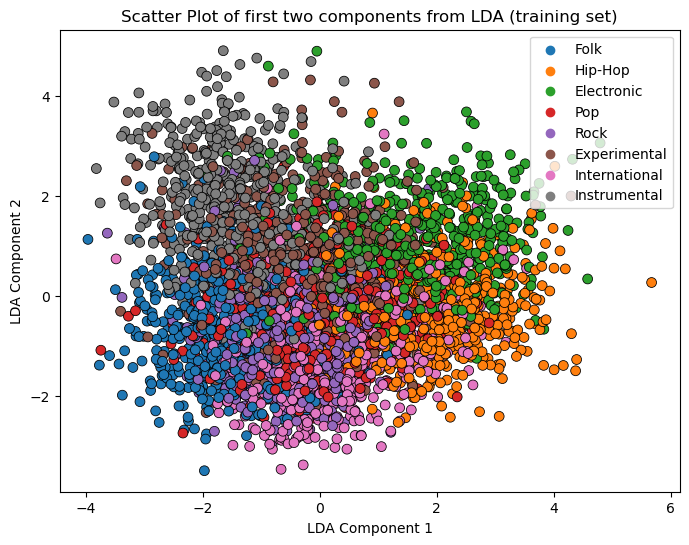

In [ ]:
### Use LDA to reduce dimension, and apply other algorithms ###

X_train_LDA = LDAclassifier.transform(X_train_scaled)
X_test_LDA = LDAclassifier.transform(X_test_scaled)

df_train_LDA = pd.DataFrame(data=X_train_LDA, columns=[f'LDA_{i}' for i in range(1, 8)])

reverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_str = [reverse_label_mapping[y] for y in y_train]


# Scatter plot of first two LDA components with colors representing class labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x='LDA_1', y='LDA_2', hue=y_train_str, data=df_train_LDA, edgecolor='black', s=50)
plt.title('Scatter Plot of first two components from LDA (training set)')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()

In [ ]:
def model_LDA(model, name):
    """
    Train a model using LDA as dimension-reduction techniquqe, 
    and assess the classification performance using accuracy and F1 score

    :param model: any object with functions `fit` and `predict` defined
    :param name: String, the name of the algorithm, will be printed 
    """

    model.fit(X_train_LDA, y_train)
    y_pred = model.predict(X_test_LDA)
    print('Test Accuracy of', name, ':', round(accuracy_score(y_test, y_pred), 5), '\n')
    print('Test set F1 score of', name, ':', round(f1_score(y_test, y_pred, average='macro'), 5), '\n')

In [ ]:
for name, algorithm in algorithms_notuning.items():
    model_LDA(algorithm, name)

Test Accuracy of naive_Bayes : 0.55583 

Test set F1 score of naive_Bayes : 0.55804 

Test Accuracy of SGD : 0.53917 

Test set F1 score of SGD : 0.53619 

Test Accuracy of Decision_tree : 0.44167 

Test set F1 score of Decision_tree : 0.43992 

Test Accuracy of random_forest : 0.55 

Test set F1 score of random_forest : 0.54636 

Test Accuracy of SVM : 0.54833 

Test set F1 score of SVM : 0.54759 

Test Accuracy of logistic_regression : 0.55333 

Test set F1 score of logistic_regression : 0.55338 



/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Test Accuracy of neural network : 0.54333 

Test set F1 score of neural network : 0.54263 

Test Accuracy of cross-gradient boosting tree : 0.53833 

Test set F1 score of cross-gradient boosting tree : 0.53713 

Test Accuracy of cross-gradient boosting : 0.56333 

Test set F1 score of cross-gradient boosting : 0.56048 



Conclusion: LDA is better than PCA for dimension reduction. Deicion trees will be discarded because the ensemble tree method always work better

## Cross-validation training

In [ ]:
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
# use LDA to reduce dimensions
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train_scaled, y_train)
X_train_LDA = LDA.transform(X_train_scaled)

In [ ]:
# SGD tuning: regularisation strength, penalty and loss 
sgd = SGDClassifier(max_iter=5000)

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'loss': list(sgd.loss_functions)
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)

    grid_SGD = GridSearchCV(sgd, param_grid, cv=5, scoring='accuracy')
    grid_SGD.fit(X_train_LDA, y_train)

In [ ]:
print(grid_SGD.best_params_)
grid_SGD.best_score_

{'alpha': 0.01, 'loss': 'log', 'penalty': 'elasticnet'}


0.703125

In [ ]:
# Random Forest tuning:  
param_grid = {
    'n_estimators': [50, 100], # number of trees
    'max_depth': [None, 5, 10],
    'min_samples_split': [8, 10, 20], # minimum size of node for splitting
    'min_samples_leaf': [2, 4, 6],  # minimum leaf size 
    'max_features': ['auto', 'sqrt', 'log2', None] # number of features used in each tree
}

rf_classifier = RandomForestClassifier()

# Perform grid search with cross-validation
grid_RF = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy',n_jobs=-1)
# without dimension-reduction
grid_RF.fit(X_train, y_train)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=7)
rf_classifier.fit(X_train_scaled, y_train)
y_pred = rf_classifier.predict(X_test_scaled)
print(accuracy_score(y_pred, y_test))

In [ ]:
print(grid_RF.best_params_)
grid_RF.best_score_

### SVM tuning

In [ ]:
from sklearn.svm import SVC

param_grid = {'C' : [0.1, 1, 5],
    'gamma' : [0.1, 0.01, 0.001],
    'kernel' : ['rbf', 'linear', 'sigmoid']
}

### dimension reduction -- chroma selection ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=466) 

# normalisation 
scaler = preprocessing.StandardScaler() # all mapped to [0, 1], uniform scaling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

chromas = {'chroma_cens', 'chroma_cqt', 'chroma_stft'}
chroma_choice = 'chroma_stft'
removed_chromas = chromas.copy()
removed_chromas.remove(chroma_choice)
removed_chromas = list(removed_chromas)
X_train_reduced = X_train_scaled[:, (X.columns.get_level_values('feature') != removed_chromas[0]) 
                            & (X.columns.get_level_values('feature') != removed_chromas[1])] 
X_test_reduced = X_test_scaled[:, (X.columns.get_level_values('feature') != removed_chromas[0]) 
                            & (X.columns.get_level_values('feature') != removed_chromas[1])]

# Create the classifier
svm = SVC(random_state=2024)

# Perform grid search with cross-validation
grid_svm = GridSearchCV(svm, param_grid, cv=8, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_reduced, y_train)

0.5991666666666666


In [ ]:
print(f'best parameters: {grid_svm.best_params_}')
grid_svm.best_score_
y_pred = grid_svm.predict(X_test_reduced)
print(accuracy_score(y_pred, y_test))

In [ ]:
# tunig gradient boosting random forest
from xgboost import XGBRFClassifier

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2], # step size shrinkage used in each boosting iteration
    'n_estimators': [50, 100], # number of trees
    'max_depth': [5, 7, 10], # max tree depth
    'subsample': [0.6, 0.8], # fraction of samples used for fitting each tree
    'colsample_bynode': [0.6, 0.8], # fraction of features used for fitting each tree
    'gamma': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition on a leaf node of the tree.
}

# Create the XGBRFClassifier
xgbrf_classifier = XGBRFClassifier(random_state=42)

# Perform grid search with cross-validation
grid_xgb = GridSearchCV(xgbrf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

In [ ]:
print(grid_xgb.best_params_)
grid_xgb.best_score_

In [ ]:
## tuning Adaboost
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier()

# Define the parameter grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200], # number of trees
    'learning_rate': [0.01, 0.1, 0.5],
    'base_estimator__max_depth': [2, 4, 6] 
}

# Create the AdaBoostClassifier
adaboost = AdaBoostClassifier(base_estimator=base_estimator)

# grid search
grid_ada = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy')
grid_ada.fit(X_train, y_train)

In [ ]:
print(grid_ada.best_params_)
grid_ada.best_score_

## MLP training using tensorflow

In [32]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, InputLayer, PReLU, LeakyReLU
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras.callbacks import EarlyStopping

In [ ]:
### dimension reduction -- LDA ### 
# use LDA
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train_scaled, y_train)
X_train_reduced = LDA.transform(X_train_scaled)
X_test_reduced = LDA.transform(X_test_scaled)

In [ ]:
### dimension reduction -- ICA ###
from sklearn.decomposition import FastICA

ICA = FastICA(n_components=40, random_state=2024)
X_train_reduced = ICA.fit_transform(X_train_scaled)
X_test_reduced = ICA.transform(X_test_scaled)

/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [22]:
### dimension reduction -- chroma selection ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=466) 

### normalisation 
scaler = preprocessing.StandardScaler() # all mapped to [0, 1], uniform scaling
# the normaliser only uses information from the training set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

chromas = {'chroma_cens', 'chroma_cqt', 'chroma_stft'}
chroma_choice = 'chroma_stft'
removed_chromas = chromas.copy()
removed_chromas.remove(chroma_choice)
removed_chromas = list(removed_chromas)
X_train_reduced = X_train_scaled[:, (X.columns.get_level_values('feature') != removed_chromas[0]) 
                            & (X.columns.get_level_values('feature') != removed_chromas[1])] 
X_test_reduced = X_test_scaled[:, (X.columns.get_level_values('feature') != removed_chromas[0]) 
                            & (X.columns.get_level_values('feature') != removed_chromas[1])]

In [104]:
from sklearn.metrics import accuracy_score
# SVM:  
X_train_selected = X_train[selected_features[:250]].drop(['chroma_cens', 'chroma_cqt'], axis=1)
# X_train_selected = X_train_selected
X_test_selected = X_test[selected_features[:250]].drop(['chroma_cens', 'chroma_cqt'], axis=1)


scaler = preprocessing.StandardScaler() # all mapped to [0, 1], uniform scaling
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

In [125]:
tf.random.set_seed(2024)
### set basic parameters
batch_size = 32
activation = 'sigmoid' # activation for the hidden layers: `relu`, `prelu`, `leakyrelu`, 'sigmoid
learning_rate = 1e-3
n_epoches = 500
dropout_rate = 0.5 # set to 0 to avoid drop-out
layer_widths = [2048] # number of hidden units in each hidden layer
normalisation = True
verbose = 1 # print output

X_train_reduced = X_train_scaled
X_test_reduced = X_test_scaled

### define architecture:
n_layers = len(layer_widths)
base_architecture = Sequential()
base_architecture.add(InputLayer(input_shape=(X_train_reduced.shape[1],)))

# feedforward neural network 
for l in range(n_layers):
    if activation == 'relu':
        base_architecture.add(Dense(layer_widths[l], activation='relu'))
    elif activation == 'sigmoid':
        base_architecture.add(Dense(layer_widths[l], activation='sigmoid'))
    else:
        base_architecture.add(Dense(layer_widths[l]))
    # dropout 
    base_architecture.add(Dropout(dropout_rate))
    # other activations
    if activation == 'prelu':
        base_architecture.add(PReLU())
    elif activation == 'leakyrelu':
        base_architecture.add(LeakyReLU())
    # normalisation
    if normalisation:
        base_architecture.add(BatchNormalization())

# add output layer
base_architecture.add(Dense(units=8, activation = 'softmax')) 

# define the model with Adam optimiser
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)

model = Sequential.from_config(base_architecture.get_config())
model.compile(optimizer=Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
history = model.fit(X_train_reduced, y_train, epochs=n_epoches, batch_size=batch_size, 
                    validation_data=(X_test_reduced, y_test), verbose=verbose, 
                    callbacks=[early_stopping])


Epoch 1/500
150/150 [==============================] - 1s 4ms/step - loss: 1.9917 - accuracy: 0.3823 - val_loss: 1.3232 - val_accuracy: 0.5650
Epoch 2/500
150/150 [==============================] - 0s 3ms/step - loss: 1.7142 - accuracy: 0.4563 - val_loss: 1.2836 - val_accuracy: 0.5592
Epoch 3/500
150/150 [==============================] - 0s 3ms/step - loss: 1.5979 - accuracy: 0.4717 - val_loss: 1.2694 - val_accuracy: 0.5658
Epoch 4/500
150/150 [==============================] - 0s 3ms/step - loss: 1.5212 - accuracy: 0.4892 - val_loss: 1.2728 - val_accuracy: 0.5567
Epoch 5/500
150/150 [==============================] - 0s 3ms/step - loss: 1.4801 - accuracy: 0.4967 - val_loss: 1.2790 - val_accuracy: 0.5792
Epoch 6/500
150/150 [==============================] - 0s 3ms/step - loss: 1.4454 - accuracy: 0.5088 - val_loss: 1.2405 - val_accuracy: 0.5842
Epoch 7/500
150/150 [==============================] - 0s 3ms/step - loss: 1.4273 - accuracy: 0.5135 - val_loss: 1.2212 - val_accuracy: 0.5667

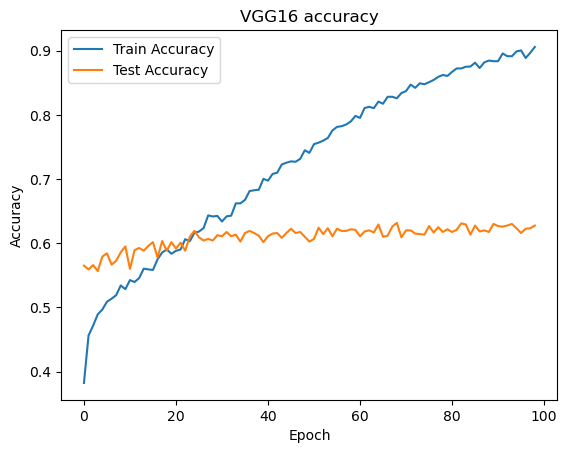

In [126]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("VGG16 accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy","Test Accuracy"])
plt.show()

test accuracy: 0.6416666666666667


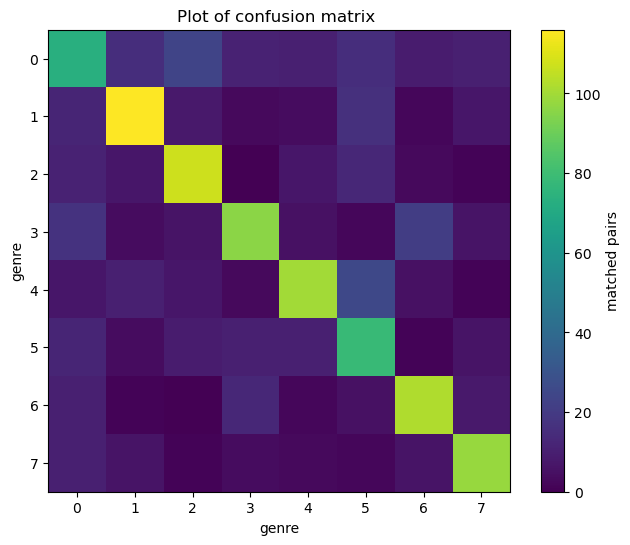

In [72]:
y_pred = np.argmax(model.predict(X_test_reduced, verbose=0), axis=1).astype(int)
print(f'test accuracy: {accuracy_score(y_pred, y_test)}')
plot_confusion(y_pred, y_test)

## Superlearner
Ensemble method of the classical classifiers described above

In [46]:
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import XGBRFClassifier
from sklearn.svm import SVC

In [ ]:
# create a list of base-models
classifiers = {}
## need to adjust the paramters !!!!!!! LDA procedure changed
classifiers['SVC'] = SVC(C=2, kernel='rbf', gamma='scale') 
classifiers['SGD_LM'] = SGDClassifier(max_iter=5000, alpha=0.001, loss='log_loss', penalty='l2')
classifiers['logistic'] = LogisticRegression(C=1, penalty='l1', solver='liblinear')
classifiers['Gradient_Boost'] = XGBRFClassifier(colsample_bynode=0.6, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6)

In [ ]:
# collect out of fold predictions form k-fold cross validation
def out_of_fold_predictions(X, y, models):
	"""
	param X: input data
	param y: class labels
	models: based models for the super-learner
	"""
	X_out, y_out = list(), list()
	# define partition of data into 10 folds
	kfold = KFold(n_splits=10, shuffle=True)
	# enumerate splits
	for train_ids, test_ids in kfold.split(X):
		y_preds = list()
		# split data
		X = np.array(X)
		X_train, X_test = X[train_ids], X[test_ids]
		y = np.array(y)
		y_train, y_test = y[train_ids], y[test_ids]
		y_out.extend(y_test)
		# fit and make predictions with each base model
		for _, model in models.items():
			model.fit(X_train, y_train)
			y_probs = model.predict_proba(X_test)
			# store columns
			y_preds.append(y_probs)
		# store fold yhats as columns
		X_out.append(np.hstack(y_preds))
	return np.vstack(X_out), np.asarray(y_out)

In [ ]:
def fit_base(X, y, models):
	for name, model in models.items():
		if name != 'MLP':
			model.fit(X, y)

## used on out-of-fold predictions
def fit_meta(X, y):
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)
    return model

def superlearner_predict(X, models, meta_model):
	meta_X = list()
	for _, model in models.items():
		y_probs = model.predict_proba(X)
		meta_X.append(y_probs)
	meta_X = np.hstack(meta_X)
	return meta_model.predict(meta_X)

In [ ]:
# use LDA to reduce dimensions
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train_scaled, y_train)
X_train_LDA = LDA.transform(X_train_scaled)
X_test_LDA = LDA.transform(X_test_scaled)

meta_X, meta_y = out_of_fold_predictions(X_train_LDA, y_train, classifiers)

fit_base(X_train_LDA, y_train, classifiers)
meta_model = fit_meta(meta_X, meta_y)

y_pred = superlearner_predict(X_test_LDA, classifiers, meta_model)
print('Super Learner test accuracy: %.3f' % (accuracy_score(y_test, y_pred) * 100))

Super Learner test accuracy: 55.333


In [ ]:
### dimension reduction -- chroma selection ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=466) 

### normalisation 
scaler = preprocessing.StandardScaler() # all mapped to [0, 1], uniform scaling
# the normaliser only uses information from the training set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

chromas = {'chroma_cens', 'chroma_cqt', 'chroma_stft'}
chroma_choice = 'chroma_stft'
removed_chromas = chromas.copy()
removed_chromas.remove(chroma_choice)
removed_chromas = list(removed_chromas)
X_train_reduced = X_train_scaled[:, (X.columns.get_level_values('feature') != removed_chromas[0]) 
                            & (X.columns.get_level_values('feature') != removed_chromas[1])] 
X_test_reduced = X_test_scaled[:, (X.columns.get_level_values('feature') != removed_chromas[0]) 
                            & (X.columns.get_level_values('feature') != removed_chromas[1])]

meta_X, meta_y = out_of_fold_predictions(X_train_reduced, y_train, classifiers)

fit_base(X_train_reduced, y_train, classifiers)
meta_model = fit_meta(meta_X, meta_y)

y_pred = superlearner_predict(X_test_reduced, classifiers, meta_model)
print('Super Learner test accuracy: %.3f' % (accuracy_score(y_test, y_pred) * 100))

## Export final prediction in csv format 

In [ ]:
X_output = pd.read_csv('data/X_test.csv', index_col = 0, header=[0, 1, 2]) # inputs of the test set
y_output = ...

In [ ]:
# Export the predictions on the test data in csv format
prediction = pd.DataFrame(y_output, columns=['Genre'])
prediction.index.name='Id'
prediction.to_csv('data/myprediction.csv') # export to csv file